In [1]:
import math
import numpy as np #pip install numpy
import pandas as pd #pip install pandas
import tensorflow as tf #pip install tensorflow
from tensorflow import keras 
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt # pip install matplotlib

In [2]:
# data = pd.read_csv("Monkey-Pox PATIENTS Dataset.csv", delimiter=',')
# data = data.drop(['Patient_ID'], axis=True)
# data = data.replace(True, 1).replace(False,0)
# data_new =  pd.get_dummies(data, columns = ['Systemic Illness']).copy()
# data_new.replace({'MonkeyPox': {'Negative': 0, 'Positive': 1}}, inplace=True)
# data_new.to_csv("final_monkey.csv", index=False)

### New Dataset (Custom)

In [3]:
dataset = pd.read_csv("final_monkey.csv")

In [4]:
dataset.head()

,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox,Systemic Illness_Fever,Systemic Illness_Muscle Aches and Pain,Systemic Illness_None,Systemic Illness_Swollen Lymph Nodes
0,0,1,1,1,0,1,0,0,0,0,0,1,0
1,1,0,1,1,0,0,1,0,1,1,0,0,0
2,0,1,1,0,0,0,1,0,1,1,0,0,0
3,1,0,0,0,1,1,1,0,1,0,0,1,0
4,1,1,1,0,0,1,1,0,1,0,0,0,1


In [85]:
X = dataset.drop(['MonkeyPox'], axis=1).values.copy()
y = dataset['MonkeyPox'].values.copy()
print(X.shape)
print(y.shape)
print(dataset['MonkeyPox'].value_counts())

(25000, 12)
(25000,)
1    15909
0     9091
Name: MonkeyPox, dtype: int64


In [131]:
from ctgan import CTGAN #pip install ctgan

gan_dataset = dataset.copy()
gan_dataset_0 = gan_dataset[gan_dataset['MonkeyPox'] == 0]
gan_dataset_1 = gan_dataset[gan_dataset['MonkeyPox'] == 1]

discrete_columns = list(gan_dataset.columns)
ctgan = CTGAN(epochs=10)
ctgan.fit(gan_dataset_0, discrete_columns)

In [132]:
print(gan_dataset_0.shape)
print(gan_dataset_1.shape)

(9091, 13)
(15909, 13)


In [133]:
# Create synthetic data
syn_gan_dataset_0 = ctgan.sample(15000)

In [134]:
syn_gan_dataset_0['MonkeyPox'].value_counts()

0    15000
Name: MonkeyPox, dtype: int64

In [135]:
syn_gan_dataset = syn_gan_dataset_0.copy()
syn_gan_dataset = syn_gan_dataset.append(gan_dataset_1, ignore_index=True)
print(syn_gan_dataset['MonkeyPox'].value_counts())
print(syn_gan_dataset.shape)

1    15909
0    15000
Name: MonkeyPox, dtype: int64
(30909, 13)


C:\Users\Hammad\AppData\Local\Temp\ipykernel_10340\2792140450.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  syn_gan_dataset = syn_gan_dataset.append(gan_dataset_1, ignore_index=True)


In [113]:
from imblearn.over_sampling import SMOTE #pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# oversample = SMOTE()
# transform the dataset
# X_S, y_S = oversample.fit_resample(X, y)


# define pipeline
over = SMOTE(sampling_strategy=0.6)
under = RandomUnderSampler(sampling_strategy=1.2)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_S, y_S = pipeline.fit_resample(X, y)

InvalidParameterError: The 'sampling_strategy' parameter of RandomUnderSampler must be a float in the range (0, 1], a str among {'auto', 'not minority', 'majority', 'all', 'not majority'}, an instance of 'collections.abc.Mapping' or a callable. Got 1.2 instead.

In [87]:
from collections import Counter
print(X_S.shape)
print(y_S.shape)
counter = Counter(y_S)
print(counter)

(19090, 12)
(19090,)
Counter({0: 9545, 1: 9545})


In [88]:
X_columns = list(dataset.columns).copy()
X_columns.remove('MonkeyPox')
oversampled_dataset = pd.DataFrame(data = X_S, columns=X_columns)
oversampled_dataset['MonkeyPox'] = y_S
oversampled_dataset.head()

,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,Systemic Illness_Fever,Systemic Illness_Muscle Aches and Pain,Systemic Illness_None,Systemic Illness_Swollen Lymph Nodes,MonkeyPox
0,0,1,1,1,0,1,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,1,1,0,1,0,1,0,0,0,0
3,0,1,1,1,1,1,0,1,0,1,0,0,0
4,1,1,0,0,1,0,0,0,0,0,0,1,0


In [89]:
print(oversampled_dataset.shape)
print(oversampled_dataset['MonkeyPox'].value_counts())

(19090, 13)
0    9545
1    9545
Name: MonkeyPox, dtype: int64


In [136]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
# train_data, test_data = train_test_split(X_S, y_S, test_size=0.2)
train_data, test_data = train_test_split(syn_gan_dataset, test_size=0.3, random_state=42)

In [137]:
print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (21636, 13)
Test dataset shape: (9273, 13)


In [138]:
dataset['MonkeyPox'].value_counts()

1    15909
0     9091
Name: MonkeyPox, dtype: int64

In [139]:
print(train_data.head(2))

       Rectal Pain  Sore Throat  Penile Oedema  Oral Lesions  Solitary Lesion  \
11866            0            1              0             0                1   
4309             1            1              1             1                0   

       Swollen Tonsils  HIV Infection  Sexually Transmitted Infection  \
11866                1              1                               1   
4309                 0              1                               1   

       MonkeyPox  Systemic Illness_Fever  \
11866          0                       0   
4309           0                       0   

       Systemic Illness_Muscle Aches and Pain  Systemic Illness_None  \
11866                                       0                      0   
4309                                        0                      1   

       Systemic Illness_Swollen Lymph Nodes  
11866                                     1  
4309                                      1  


In [140]:
train_data[train_data.columns.values] = train_data[train_data.columns.values].astype(str)
test_data[test_data.columns.values] = test_data[test_data.columns.values].astype(str)

In [141]:
train_data['Penile Oedema'] = train_data['Penile Oedema'].apply(
    lambda value: int(value)
)

test_data['Penile Oedema'] = test_data['Penile Oedema'].apply(
    lambda value: int(value)
)

In [142]:
train_data['Sexually Transmitted Infection'] = train_data['Sexually Transmitted Infection'].apply(
    lambda value: int(value)
)

test_data['Sexually Transmitted Infection'] = test_data['Sexually Transmitted Infection'].apply(
    lambda value: int(value)
)

In [143]:
# train_data['MonkeyPox'] = train_data['MonkeyPox'].apply(
#     lambda value: str(value)
# )

# test_data['MonkeyPox'] = test_data['MonkeyPox'].apply(
#     lambda value: str(value)
# )

In [144]:
print(train_data.dtypes)

Rectal Pain                               object
Sore Throat                               object
Penile Oedema                              int64
Oral Lesions                              object
Solitary Lesion                           object
Swollen Tonsils                           object
HIV Infection                             object
Sexually Transmitted Infection             int64
MonkeyPox                                 object
Systemic Illness_Fever                    object
Systemic Illness_Muscle Aches and Pain    object
Systemic Illness_None                     object
Systemic Illness_Swollen Lymph Nodes      object
dtype: object


In [145]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [146]:
TARGET_FEATURE_NAME = "MonkeyPox"

CATEGORICAL_FEATURE_NAMES = []
NUMERIC_FEATURE_NAMES = []
for i in dataset.columns:
    if train_data[i].dtype == 'object':
        CATEGORICAL_FEATURE_NAMES.append(i)
    if train_data[i].dtype == 'int64' or train_data[i].dtype == 'float64':
        NUMERIC_FEATURE_NAMES.append(i)

# A list of all the input features.
ALL_FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
print("All Feature: ", ALL_FEATURE_NAMES)
print("Length:", len(ALL_FEATURE_NAMES))

CATEGORICAL_FEATURE_NAMES = list(set(CATEGORICAL_FEATURE_NAMES) - set([TARGET_FEATURE_NAME]))
NUMERIC_FEATURE_NAMES = list(set(NUMERIC_FEATURE_NAMES) - set([TARGET_FEATURE_NAME]))

print("Cat Features: ", CATEGORICAL_FEATURE_NAMES)
print("Length:", len(CATEGORICAL_FEATURE_NAMES))
print("Num Features: ", NUMERIC_FEATURE_NAMES)
print("Length:", len(NUMERIC_FEATURE_NAMES))

All Feature:  ['Penile Oedema', 'Sexually Transmitted Infection', 'Rectal Pain', 'Sore Throat', 'Oral Lesions', 'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection', 'MonkeyPox', 'Systemic Illness_Fever', 'Systemic Illness_Muscle Aches and Pain', 'Systemic Illness_None', 'Systemic Illness_Swollen Lymph Nodes']
Length: 13
Cat Features:  ['Systemic Illness_Fever', 'Oral Lesions', 'Systemic Illness_Muscle Aches and Pain', 'Systemic Illness_None', 'Solitary Lesion', 'HIV Infection', 'Rectal Pain', 'Sore Throat', 'Swollen Tonsils', 'Systemic Illness_Swollen Lymph Nodes']
Length: 10
Num Features:  ['Penile Oedema', 'Sexually Transmitted Infection']
Length: 2


In [147]:
# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "Penile Oedema"

COLUMN_DEFAULTS_String = NUMERIC_FEATURE_NAMES 

if WEIGHT_COLUMN_NAME != "":
    if WEIGHT_COLUMN_NAME in NUMERIC_FEATURE_NAMES:
        COLUMN_DEFAULTS_String = NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME]
        NUMERIC_FEATURE_NAMES = list(set(NUMERIC_FEATURE_NAMES) - set([WEIGHT_COLUMN_NAME]))
        print("Num Features (Updated): ", NUMERIC_FEATURE_NAMES)
        print("Length:", len(NUMERIC_FEATURE_NAMES))
    else:    
        CATEGORICAL_FEATURE_NAMES = list(set(CATEGORICAL_FEATURE_NAMES) - set([WEIGHT_COLUMN_NAME]))
        print("Cat Features (Updated): ", CATEGORICAL_FEATURE_NAMES)
        print("Length:", len(CATEGORICAL_FEATURE_NAMES))   

CATEGORICAL_FEATURES_WITH_VOCABULARY = {}
for val in CATEGORICAL_FEATURE_NAMES:
    CATEGORICAL_FEATURES_WITH_VOCABULARY[val] = sorted(list(train_data[val].unique()))
print("Cat Features with Vocab: " , CATEGORICAL_FEATURES_WITH_VOCABULARY)
print("Length:", len(CATEGORICAL_FEATURES_WITH_VOCABULARY))

Num Features (Updated):  ['Sexually Transmitted Infection']
Length: 1
Cat Features with Vocab:  {'Systemic Illness_Fever': ['0', '1'], 'Oral Lesions': ['0', '1'], 'Systemic Illness_Muscle Aches and Pain': ['0', '1'], 'Systemic Illness_None': ['0', '1'], 'Solitary Lesion': ['0', '1'], 'HIV Infection': ['0', '1'], 'Rectal Pain': ['0', '1'], 'Sore Throat': ['0', '1'], 'Swollen Tonsils': ['0', '1'], 'Systemic Illness_Swollen Lymph Nodes': ['0', '1']}
Length: 10


In [148]:
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
print("Feature Names: ", FEATURE_NAMES)
print("Length:", len(FEATURE_NAMES))

# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in COLUMN_DEFAULTS_String else ["NA"]
    for feature_name in ALL_FEATURE_NAMES
]
print("Column Defaults: ", COLUMN_DEFAULTS)
print("Length:", len(COLUMN_DEFAULTS))

# A list of the labels of the target features.
TARGET_LABELS = list(dataset[TARGET_FEATURE_NAME].astype(str).unique())
print("Label Target: ", TARGET_LABELS)

TARGET_LABELS1 = list(train_data[TARGET_FEATURE_NAME].unique())
print("Label Target1: ", TARGET_LABELS1)

Feature Names:  ['Sexually Transmitted Infection', 'Systemic Illness_Fever', 'Oral Lesions', 'Systemic Illness_Muscle Aches and Pain', 'Systemic Illness_None', 'Solitary Lesion', 'HIV Infection', 'Rectal Pain', 'Sore Throat', 'Swollen Tonsils', 'Systemic Illness_Swollen Lymph Nodes']
Length: 11
Column Defaults:  [[0.0], [0.0], ['NA'], ['NA'], ['NA'], ['NA'], ['NA'], ['NA'], ['NA'], ['NA'], ['NA'], ['NA'], ['NA']]
Length: 13
Label Target:  ['0', '1']
Label Target1:  ['0', '1']


In [149]:
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 0.0003
DROPOUT_RATE = 0.1
BATCH_SIZE = 64
NUM_EPOCHS = 35

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

In [150]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    weights = features.pop(WEIGHT_COLUMN_NAME)
    return features, target_index, weights
    # return features, target_index


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=ALL_FEATURE_NAMES, # updated
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()

c:\Users\Hammad\Documents\Python_Envs\bert_trans_env\lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [151]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [152]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics = ['acc',f1_m,precision_m, recall_m]
        # metrics=[keras.metrics.BinaryAccuracy(name="accuracy"), keras.metrics.BinaryCrossentropy(mer="acc")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    loss, accuracy, f1_score, precision, recall = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%, Precision: {round(precision * 100, 2)}, Recall: {round(recall * 100, 2)}, F1-Score: {round(f1_score * 100, 2)}")

    return history

In [153]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [154]:
def encode_inputs(inputs, embedding_dims):

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

In [155]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

### Baseline Model (Transformer Classifier)

In [156]:
def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")


Total model weights: 158101
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [157]:
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/35
    338/Unknown - 5s 7ms/step - loss: 0.2892 - acc: 0.6944 - f1_m: 0.7253 - precision_m: 0.6706 - recall_m: 0.7992WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.
339/339 [==============================] - 7s 11ms/step - loss: 0.2892 - acc: 0.6944 - f1_m: 0.7255 - precision_m: 0.6706 - recall_m: 0.7998 - val_loss: 0.2157 - val_acc: 0.7926 - val_f1_m: 0.8272 - val_precision_m: 0.7140 - val_recall_m: 0.9887
Epoch 2/35
339/339 [==============================] - 3s 9ms/step - loss: 0.2128 - acc: 0.7899 - f1_m: 0.8191 - precision_m: 0.7348 - recall_m: 0.9322 - val_loss: 0.2149 - val_acc: 0.7827 - val_f1_m: 0.8154 - val_precision_m: 0.7139 - val_recall_m: 0.9561
Epoch 3/35
339/339 [==============================] - 3s 

### Tab Transformer Classifier

In [158]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    if encoded_categorical_feature_list != []:
        encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    else:
        encoded_categorical_features = [[]]
    # print(encoded_categorical_features)

    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features) # (None, 10, 16)
        # print(attention_output)

        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )

        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [159]:
tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

Total model weights: 119311
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [161]:
print(NUM_EPOCHS, LEARNING_RATE, WEIGHT_DECAY, BATCH_SIZE)

35 0.0005 0.0003 64


In [162]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=20,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/20
    338/Unknown - 24s 31ms/step - loss: 0.1949 - acc: 0.7983 - f1_m: 0.8331 - precision_m: 0.7250 - recall_m: 0.9848WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.
339/339 [==============================] - 26s 38ms/step - loss: 0.1949 - acc: 0.7982 - f1_m: 0.8326 - precision_m: 0.7244 - recall_m: 0.9849 - val_loss: 1.9655 - val_acc: 0.3293 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
339/339 [==============================] - 11s 32ms/step - loss: 0.1941 - acc: 0.7998 - f1_m: 0.8329 - precision_m: 0.7274 - recall_m: 0.9802 - val_loss: 0.1954 - val_acc: 0.8035 - val_f1_m: 0.8322 - val_precision_m: 0.7312 - val_recall_m: 0.9703
Epoch 3/20
339/339 [====================

### LSTM

In [163]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout,Activation

In [164]:
lstm_data = syn_gan_dataset.drop(['MonkeyPox'], axis = 1).copy()
lstm_data = lstm_data.values
print(lstm_data.shape)

lstm_label = syn_gan_dataset['MonkeyPox'].values
print(lstm_label.shape)

(30909, 12)
(30909,)


In [165]:
print(dataset.dtypes)

Rectal Pain                               int64
Sore Throat                               int64
Penile Oedema                             int64
Oral Lesions                              int64
Solitary Lesion                           int64
Swollen Tonsils                           int64
HIV Infection                             int64
Sexually Transmitted Infection            int64
MonkeyPox                                 int64
Systemic Illness_Fever                    int64
Systemic Illness_Muscle Aches and Pain    int64
Systemic Illness_None                     int64
Systemic Illness_Swollen Lymph Nodes      int64
dtype: object


In [166]:
X1 = lstm_data.reshape((-1, 1, lstm_data.shape[1]))

In [167]:
X1.shape

(30909, 1, 12)

In [168]:
trainX, testX, trainY, testY = train_test_split(X1, lstm_label, test_size = 0.30, random_state = 5)

In [169]:
# 1 LSTM Layer (input), 3 Dense Hidden Layers
model = Sequential()
model.add(LSTM(17, input_shape=(1, lstm_data.shape[1]), activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m,recall_m])
model.fit(trainX, trainY, epochs=35, batch_size=64, verbose=2, validation_data=(testX, testY))

Epoch 1/35
339/339 - 11s - loss: 0.6446 - accuracy: 0.6276 - f1_m: 0.6437 - precision_m: 0.6379 - recall_m: 0.6652 - val_loss: 0.6194 - val_accuracy: 0.6716 - val_f1_m: 0.6909 - val_precision_m: 0.6618 - val_recall_m: 0.7287 - 11s/epoch - 32ms/step
Epoch 2/35
339/339 - 2s - loss: 0.5692 - accuracy: 0.7064 - f1_m: 0.7140 - precision_m: 0.7092 - recall_m: 0.7295 - val_loss: 0.4765 - val_accuracy: 0.7636 - val_f1_m: 0.7571 - val_precision_m: 0.7886 - val_recall_m: 0.7330 - 2s/epoch - 7ms/step
Epoch 3/35
339/339 - 2s - loss: 0.4700 - accuracy: 0.7701 - f1_m: 0.7871 - precision_m: 0.7478 - recall_m: 0.8410 - val_loss: 0.4109 - val_accuracy: 0.8086 - val_f1_m: 0.8332 - val_precision_m: 0.7464 - val_recall_m: 0.9479 - 2s/epoch - 7ms/step
Epoch 4/35
339/339 - 2s - loss: 0.4390 - accuracy: 0.7855 - f1_m: 0.8058 - precision_m: 0.7497 - recall_m: 0.8783 - val_loss: 0.4005 - val_accuracy: 0.8074 - val_f1_m: 0.8254 - val_precision_m: 0.7634 - val_recall_m: 0.9037 - 2s/epoch - 7ms/step
Epoch 5/35
33

In [170]:
loss, accuracy, f1_score, precision, recall = model.evaluate(testX, testY)
print("Loss:" + str(loss))
print(f"Validation accuracy: {round(accuracy * 100, 2)}%, Precision: {round(precision * 100, 2)}, Recall: {round(recall * 100, 2)}, F1-Score: {round(f1_score * 100, 2)}")

290/290 [==============================] - 1s 4ms/step - loss: 0.3918 - accuracy: 0.8089 - f1_m: 0.8265 - precision_m: 0.7563 - recall_m: 0.9213
Loss:0.391750693321228
Validation accuracy: 80.89%, Precision: 75.63, Recall: 92.13, F1-Score: 82.65


In [171]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 17)                2040      
                                                                 
 dropout_21 (Dropout)        (None, 17)                0         
                                                                 
 dense_21 (Dense)            (None, 128)               2304      
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 100)               12900     
                                                                 
 dropout_23 (Dropout)        (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 64)                6

### Dataset Stats

In [172]:
import seaborn as sns
corr = syn_gan_dataset.corr()

In [173]:
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\Hammad\AppData\Local\Temp\ipykernel_10340\1928666696.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox,Systemic Illness_Fever,Systemic Illness_Muscle Aches and Pain,Systemic Illness_None,Systemic Illness_Swollen Lymph Nodes
Rectal Pain,1.00,-0.00,-0.01,0.01,-0.01,0.01,-0.00,-0.01,0.10,-0.01,0.00,-0.01,0.00
Sore Throat,-0.00,1.00,-0.00,-0.01,-0.01,0.01,-0.00,-0.01,-0.02,-0.01,0.02,-0.00,-0.01
Penile Oedema,-0.01,-0.00,1.00,-0.00,0.00,0.00,-0.00,-0.02,-0.04,-0.01,0.01,0.02,-0.01
Oral Lesions,0.01,-0.01,-0.00,1.00,-0.01,0.00,0.00,-0.01,0.13,0.01,-0.00,-0.02,0.02
Solitary Lesion,-0.01,-0.01,0.00,-0.01,1.00,-0.00,-0.02,0.00,-0.07,-0.01,0.01,0.02,-0.03
Swollen Tonsils,0.01,0.01,0.00,0.00,-0.00,1.00,-0.01,-0.00,0.03,0.00,0.01,0.00,0.01
HIV Infection,-0.00,-0.00,-0.00,0.00,-0.02,-0.01,1.00,-0.01,0.12,0.01,0.00,-0.01,-0.00
Sexually Transmitted Infection,-0.01,-0.01,-0.02,-0.01,0.00,-0.00,-0.01,1.00,0.04,0.00,0.01,0.00,-0.01
MonkeyPox,0.10,-0.02,-0.04,0.13,-0.07,0.03,0.12,0.04,1.00,0.14,-0.11,-0.13,0.14
Systemic Illness_Fever,-0.01,-0.01,-0.01,0.01,-0.01,0.00,0.01,0.00,0.14,1.00,-0.18,-0.18,-0.23


<Axes: >

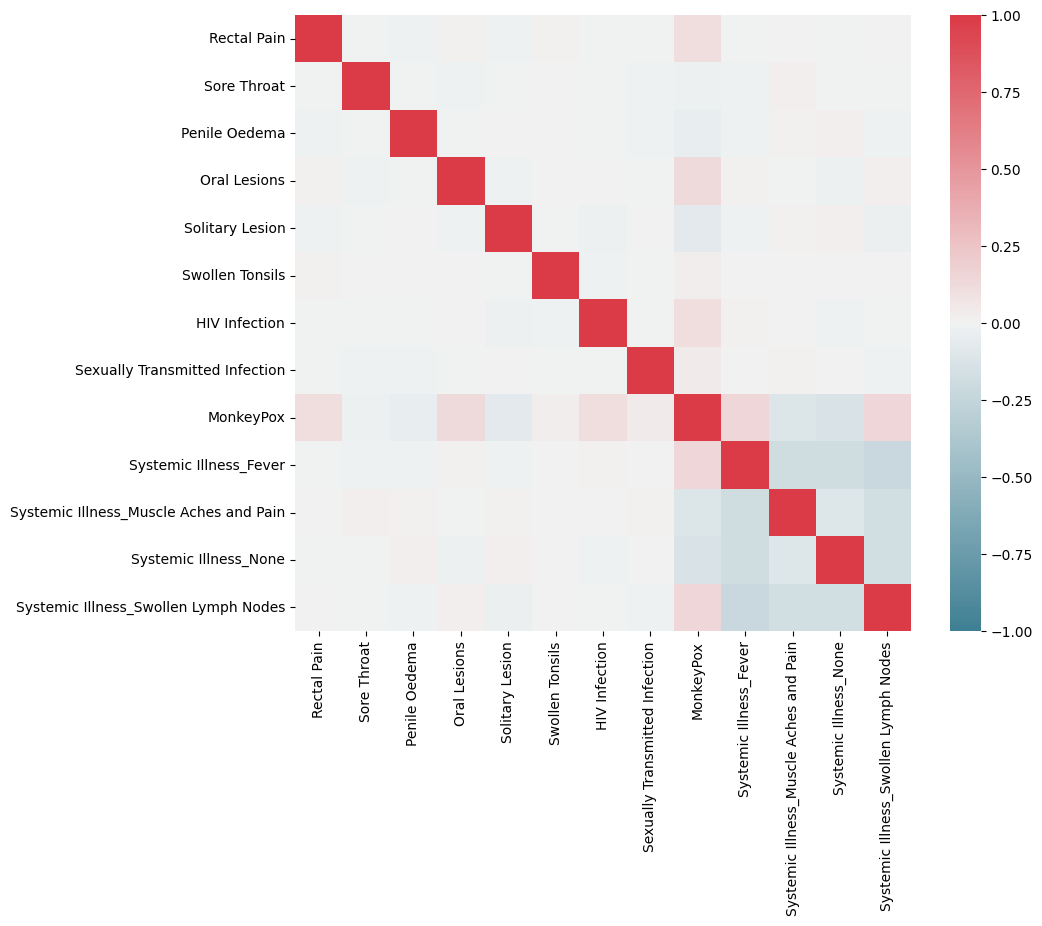

In [174]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

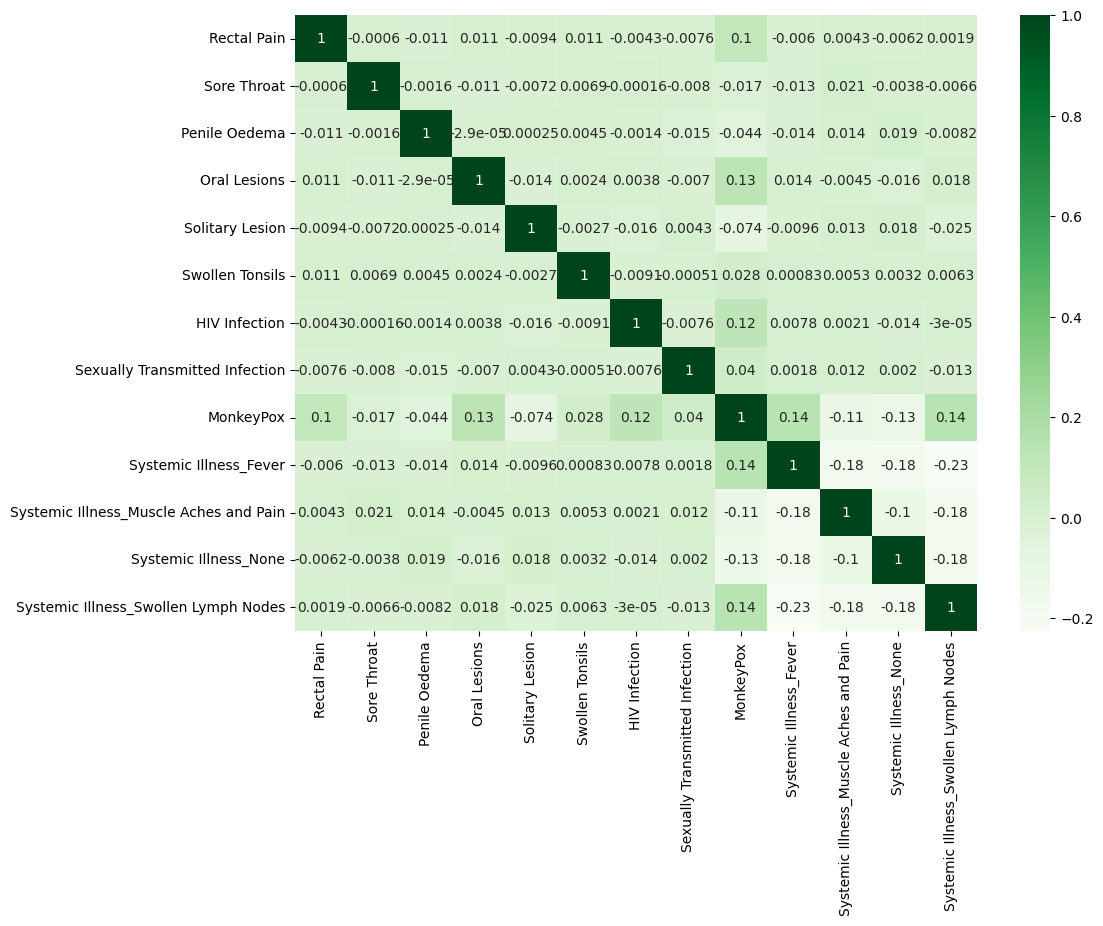

In [175]:
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

In [176]:
import scipy.stats as stats
import researchpy as rp
onesample_results = stats.ttest_1samp(syn_gan_dataset, 0) 

In [177]:
rp.summary_cont(dataset)

c:\Users\Hammad\Documents\Python_Envs\bert_trans_env\lib\site-packages\researchpy\summary.py:60: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ix, df_col in group1.iteritems():


,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Rectal Pain,25000.0,0.4938,0.5000,0.0032,0.4876,0.5000
1,Sore Throat,25000.0,0.5022,0.5000,0.0032,0.4960,0.5084
2,Penile Oedema,25000.0,0.5045,0.5000,0.0032,0.4983,0.5107
3,Oral Lesions,25000.0,0.4994,0.5000,0.0032,0.4932,0.5056
4,Solitary Lesion,25000.0,0.5011,0.5000,0.0032,0.4949,0.5073
5,Swollen Tonsils,25000.0,0.5013,0.5000,0.0032,0.4951,0.5075
6,HIV Infection,25000.0,0.5034,0.5000,0.0032,0.4972,0.5096
7,Sexually Transmitted Infection,25000.0,0.4978,0.5000,0.0032,0.4916,0.5040
8,MonkeyPox,25000.0,0.6364,0.4811,0.0030,0.6304,0.6423
9,Systemic Illness_Fever,25000.0,0.2553,0.4360,0.0028,0.2499,0.2607


In [178]:
syn_gan_dataset.var()

Rectal Pain                               0.250002
Sore Throat                               0.248817
Penile Oedema                             0.247601
Oral Lesions                              0.248141
Solitary Lesion                           0.247407
Swollen Tonsils                           0.249952
HIV Infection                             0.250000
Sexually Transmitted Infection            0.249377
MonkeyPox                                 0.249792
Systemic Illness_Fever                    0.183426
Systemic Illness_Muscle Aches and Pain    0.187373
Systemic Illness_None                     0.194813
Systemic Illness_Swollen Lymph Nodes      0.177279
dtype: float64

In [179]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from numpy import set_printoptions

In [180]:
# feature extraction
test = SelectKBest(score_func=f_classif, k=4)
X = syn_gan_dataset.drop(['MonkeyPox'], axis = 1).copy()
y = syn_gan_dataset['MonkeyPox'].values

fit = test.fit(X, y)

col_weight = {}
for col,val in zip(X.columns.values, list(fit.scores_)):
    col_weight[col] = val

print(sorted(col_weight.items(), key=lambda x:x[1], reverse=True))

[('Systemic Illness_Swollen Lymph Nodes', 626.5598033035652), ('Systemic Illness_Fever', 623.750198854103), ('Systemic Illness_None', 539.397705867472), ('Oral Lesions', 521.133126218548), ('HIV Infection', 414.46610616743834), ('Systemic Illness_Muscle Aches and Pain', 392.7193814234355), ('Rectal Pain', 324.14231963715963), ('Solitary Lesion', 170.38575642704086), ('Penile Oedema', 59.53980791926132), ('Sexually Transmitted Infection', 49.294683318089135), ('Swollen Tonsils', 25.021317012963372), ('Sore Throat', 9.270604640409616)]


In [181]:
dataset_varience = [('Systemic Illness_Swollen Lymph Nodes', 626.5598033035652), ('Systemic Illness_Fever', 623.750198854103), ('Systemic Illness_None', 539.397705867472), ('Oral Lesions', 521.133126218548), ('HIV Infection', 414.46610616743834), ('Systemic Illness_Muscle Aches and Pain', 392.7193814234355), ('Rectal Pain', 324.14231963715963), ('Solitary Lesion', 170.38575642704086), ('Penile Oedema', 59.53980791926132), ('Sexually Transmitted Infection', 49.294683318089135), ('Swollen Tonsils', 25.021317012963372), ('Sore Throat', 9.270604640409616)]
dataset_varience1 = sorted(dataset_varience)
dataset_varience1

[('HIV Infection', 414.46610616743834),
 ('Oral Lesions', 521.133126218548),
 ('Penile Oedema', 59.53980791926132),
 ('Rectal Pain', 324.14231963715963),
 ('Sexually Transmitted Infection', 49.294683318089135),
 ('Solitary Lesion', 170.38575642704086),
 ('Sore Throat', 9.270604640409616),
 ('Swollen Tonsils', 25.021317012963372),
 ('Systemic Illness_Fever', 623.750198854103),
 ('Systemic Illness_Muscle Aches and Pain', 392.7193814234355),
 ('Systemic Illness_None', 539.397705867472),
 ('Systemic Illness_Swollen Lymph Nodes', 626.5598033035652)]

In [182]:
features = []
varience = []
for val, scr in dataset_varience1:
    features.append(val)
    varience.append(scr)

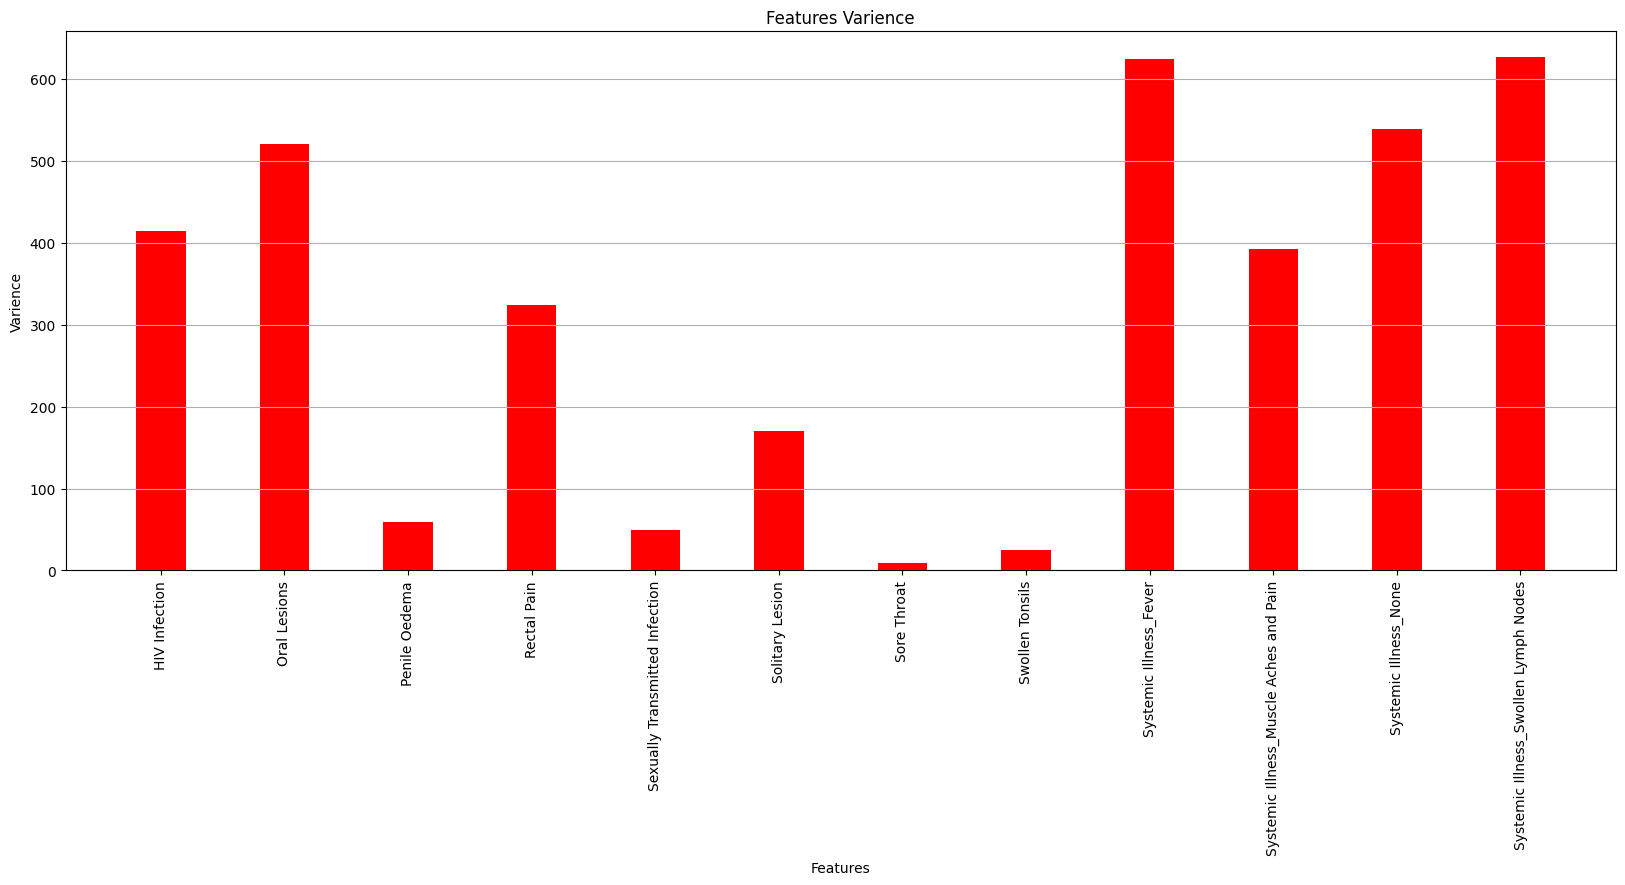

In [183]:

fig = plt.figure(figsize = (20, 7))
 
# creating the bar plot
plt.bar(features, varience, color ='red', width = 0.4)
 
# plt.xlabel("Deep Learning Models")
plt.ylabel("Varience")
plt.xlabel("Features")
plt.title("Features Varience")
plt.grid(axis = 'y')
plt.xticks(rotation=90)
plt.savefig("features_varience.png", format='png', bbox_inches='tight')
plt.show()

### Gradient Boosting Machine

In [184]:
from xgboost import XGBClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean, std

In [185]:
X = syn_gan_dataset.drop(['MonkeyPox'], axis=1).values
y = syn_gan_dataset['MonkeyPox'].values

# define the model
model = GradientBoostingClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print('Mean Accuracy: %.2f%%' % (accuracy*100))
print(classification_report(y_test, predictions)) 

Mean Accuracy: 81.53%
              precision    recall  f1-score   support

           0       0.90      0.69      0.78      4430
           1       0.77      0.93      0.84      4843

    accuracy                           0.82      9273
   macro avg       0.83      0.81      0.81      9273
weighted avg       0.83      0.82      0.81      9273



### XGBoost

In [186]:
model = XGBClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print('Mean Accuracy: %.2f%%' % (accuracy*100))
print(classification_report(y_test, predictions))

Mean Accuracy: 80.89%
              precision    recall  f1-score   support

           0       0.89      0.69      0.77      4430
           1       0.76      0.92      0.83      4843

    accuracy                           0.81      9273
   macro avg       0.83      0.80      0.80      9273
weighted avg       0.82      0.81      0.81      9273



### LightGBM

In [187]:
from lightgbm import LGBMClassifier

In [188]:
model = LGBMClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print('Mean Accuracy: %.2f%%' % (accuracy*100))
print(classification_report(y_test, predictions)) 

Mean Accuracy: 81.27%
              precision    recall  f1-score   support

           0       0.89      0.69      0.78      4430
           1       0.77      0.93      0.84      4843

    accuracy                           0.81      9273
   macro avg       0.83      0.81      0.81      9273
weighted avg       0.83      0.81      0.81      9273



### Analytics

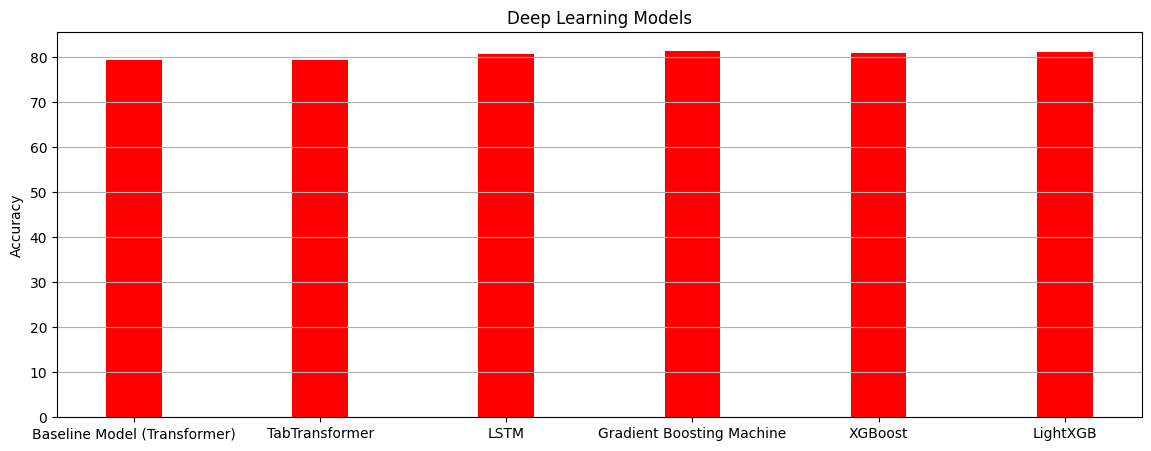

In [189]:
import numpy as np
import matplotlib.pyplot as plt
 
# creating the dataset
data = {'Baseline Model (Transformer)':79.53, 'TabTransformer':79.51, 'LSTM':80.84, "Gradient Boosting Machine":81.53, "XGBoost":80.89, "LightXGB":81.27}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (14, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='red', width = 0.3)
 
# plt.xlabel("Deep Learning Models")
plt.ylabel("Accuracy")
plt.title("Deep Learning Models")
plt.grid(axis = 'y')
plt.show()

In [190]:
results_columns = ["Accuracy", "Precision", "Recall", "F1-Score"]
basemodel_transformer_results = [79.53, 71.31, 100.0, 83.07] #accuracy: 79.53%, Precision: 71.31, Recall: 100.0, F1-Score: 83.07
tab_transformer_results = [79.51, 77.08, 85.07, 80.67] #val_acc: 0.7951 - val_f1_m: 0.8067 - val_precision_m: 0.7708 - val_recall_m: 0.8507
lstm_results = [80.84, 75.65, 92.15, 82.67] #accuracy: 0.8084 - f1_m: 0.8267 - precision_m: 0.7565 - recall_m: 0.9215
gbm_results = [81.53, 83.00, 81.00, 81.00]
xbg_results = [80.89, 83.00, 80.00, 80.00]
lgbm_results = [82.27, 83.00, 81.00, 81.00]

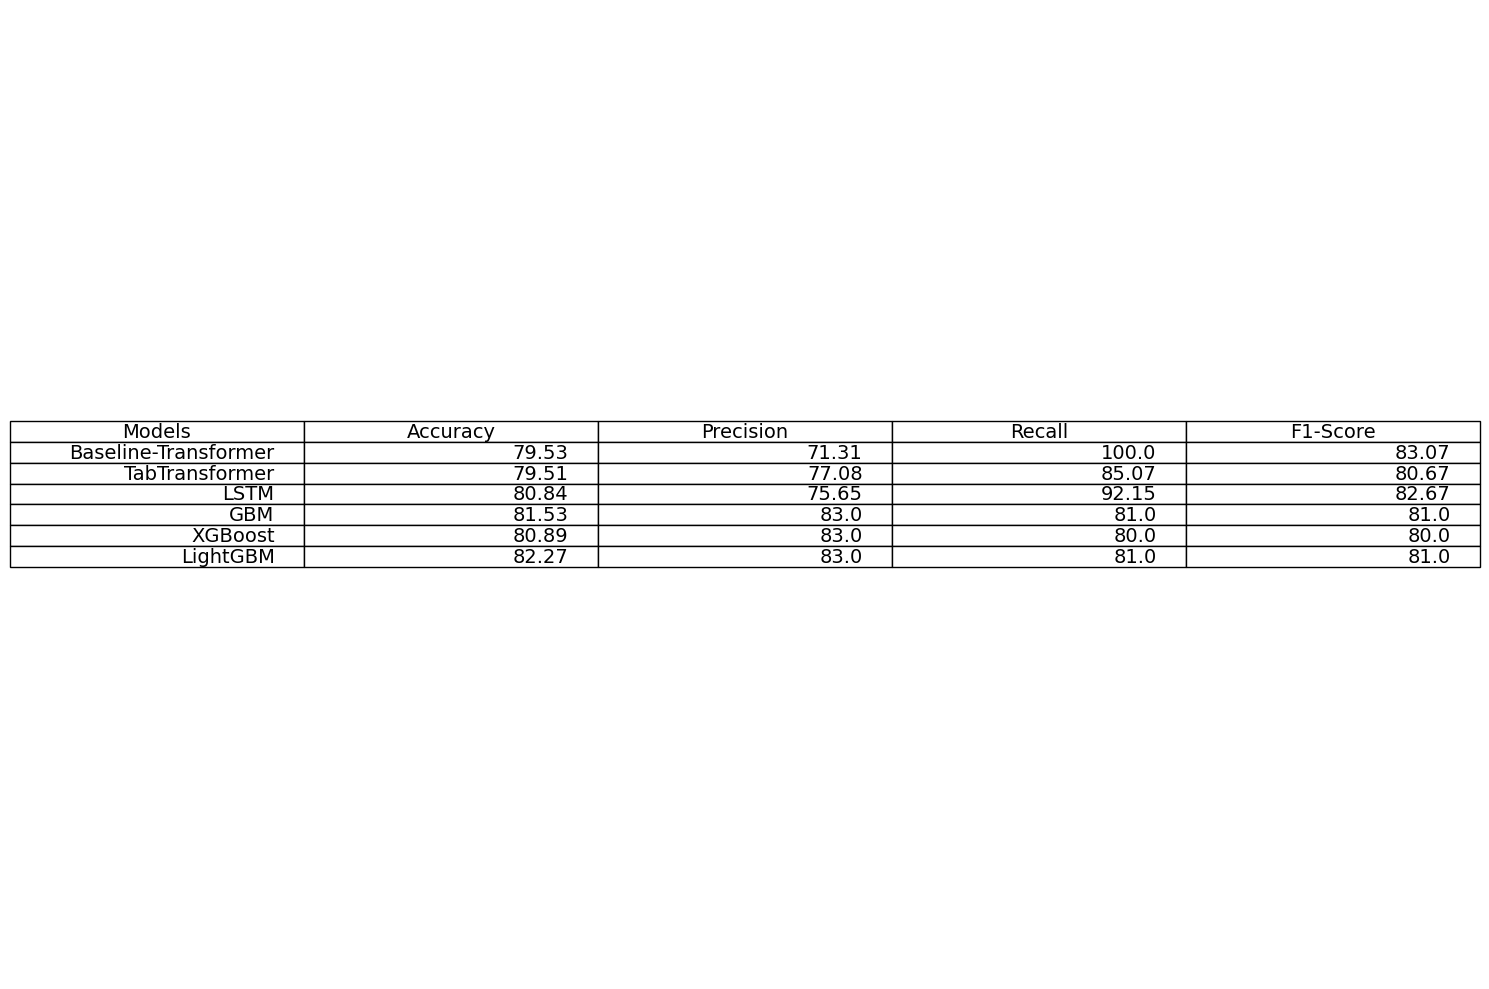

In [191]:
fig, ax = plt.subplots(figsize=(15,10))

# hide axes
fig.patch.set_visible(False)
ax.axis('off')

df = pd.DataFrame([basemodel_transformer_results, tab_transformer_results, lstm_results, gbm_results, xbg_results, lgbm_results], columns=results_columns)
df.insert(loc=0, column="Models", value=["Baseline-Transformer", "TabTransformer", "LSTM", "GBM", "XGBoost", "LightGBM"])

model_table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
model_table.auto_set_font_size(False)
model_table.set_fontsize(14)

fig.tight_layout()
fig.savefig("Comarision_models(all).png", format="png", bbox_inches='tight')

plt.show()